In [1]:
import pandas as pd
from textgame_gen import gen_prompts

data = gen_prompts(22) #1-24
print(data)
df = pd.DataFrame(data)

[{'entities': 2, 'clues': 1, 'prompt': 'Sarah, Dean walk into a fruit store. There are only 2 fruits apple, pear. Each person gets a different fruit. Dean gives Sarah the apple. Dean can have the', 'answer': 'pear'}, {'entities': 3, 'clues': 1, 'prompt': 'Jack, Dean, Sarah walk into a fruit store. There are only 3 fruits peach, pear, apple. Each person gets a different fruit. Sarah gets the apple. Jack can have the', 'answer': 'peach,pear'}, {'entities': 3, 'clues': 2, 'prompt': 'Jack, Dean, Sarah walk into a fruit store. There are only 3 fruits peach, pear, apple. Each person gets a different fruit. Sarah gets the apple. Dean gives Jack the peach. Dean can have the', 'answer': 'pear'}, {'entities': 4, 'clues': 1, 'prompt': 'Dean, Sarah, Jack, Kate walk into a fruit store. There are only 4 fruits peach, apple, pear, grape. Each person gets a different fruit. Jack gets the pear. Kate can have the', 'answer': 'peach,apple,grape'}, {'entities': 4, 'clues': 2, 'prompt': 'Dean, Sarah, Jack,

In [2]:
# @title Intalls
%pip install torch torchvision torchaudio torchtext
%pip install circuitsvis
%pip install accelerate

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
print(sys.executable)
# %pip install 'transformers[torch]'
# %uv pip install 'transformers[torch]'
# %pip install git+https://github.com/neelnanda-io/TransformerLens

%pip install plotly
%pip install fancy_einsum
%pip install jaxtyping
%pip install einops
%pip install datasets
%pip install seaborn


/Users/jesswan/Desktop/CS2222-LLM-State-Dynamics/tlens-env-1/bin/python
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# @title Imports
# Import stuff

import plotly.io as pio
import plotly.graph_objects as go
import accelerate
pio.renderers.default = "colab"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from torch import Tensor
from typing import List, Union, Optional, Tuple
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
import circuitsvis as cv

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens import HookedTransformer, HookedTransformerConfig, ActivationCache

/Users/jesswan/Desktop/CS2222-LLM-State-Dynamics/tlens-env-1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
torch.set_grad_enabled(False)

In [6]:
# @title Model Init

model = HookedTransformer.from_pretrained(
    #'pythia-70m',
    #'pythia-70m-deduped',
    #'pythia-160m',
    #'pythia-410m',
    #'pythia-1b',
    #'pythia-1.4b',
    #'pythia-160m-deduped',
    #'gpt2-medium',
    'gpt2-xl', # didnt work
    #'tiny-stories-1M',
    #'tiny-stories-3M',
    #'tiny-stories-8M',
    #'tiny-stories-28M',
    #'tiny-stories-33M',
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    low_cpu_mem_usage=True
) #transformer lens automatically assigns the model to a device, but set a variable for later
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #set the device if a GPU is available


############################################################################################################

## trying to standardize avg prob per (entity, trainsition) pair:

from collections import defaultdict



Loaded pretrained model gpt2-xl into HookedTransformer


In [7]:
# @title Run Model
# Collect probabilities by (entity_count, transition_count)
grouped_probs = defaultdict(list)
k = 5

for idx, row in df.iterrows():
    prompt = row["prompt"]
    answer = row["answer"].split(",")
    answer = [' ' + s.strip() for s in answer]
    entities = row["entities"]
    clues = row["clues"]



    print(prompt, answer)

    try:
        print( "################################")
        tokens = model.to_tokens(prompt, prepend_bos=True)
        logits = model(tokens)
        last_logits = logits[0, -1]
        probs = torch.nn.functional.softmax(last_logits, dim=-1)

        top_k = torch.topk(probs, k=k)
        for i in range(k):
            token = top_k.indices[i]
            print(f"{i+1}: {token}, {model.to_string(token)} — {top_k.values[i].item():.4f}")

        correct_token_id = model.to_tokens(answer).flatten()
        print("answer token: ", answer, correct_token_id)
        correct_prob = 0
        for t in correct_token_id:
            correct_prob = max(correct_prob, probs[t].item())

        print("Correct Answer:", correct_prob)
        #predictions = model.to_string(probs)
        grouped_probs[(entities, clues)].append(correct_prob)

        # print(predictions)
    except Exception as e:
        print(f"Skipping index {idx} due to error: {e}")
        continue

##Aggregate
records = []
print(grouped_probs)
for (entities, clues), prob_list in grouped_probs.items():
    if not prob_list:
        continue
    records.append({
        "entities": entities,
        "clues": clues,
        "avg_correct_prob": sum(prob_list) / len(prob_list),
        "n_prompts": len(prob_list)
    })

summary_df = pd.DataFrame.from_records(records)
summary_df = summary_df.sort_values(by=["entities", "clues"]).reset_index(drop=True)

print(summary_df)

Dean, Sarah walk into a fruit store. There are only 2 fruits pear, apple. Each person gets a different fruit. Sarah gives Dean the pear. Sarah can have the [' apple']
################################
1: 17180,  apple — 0.8544
2: 25286,  pear — 0.0583
3: 8234,  fruit — 0.0131
4: 584,  other — 0.0121
5: 22514,  apples — 0.0118
answer token:  [' apple'] tensor([50256, 17180], device='mps:0')
Correct Answer: 0.8543817400932312
Jack, Dean, Sarah walk into a fruit store. There are only 3 fruits apple, peach, pear. Each person gets a different fruit. Dean gives Sarah the pear. Jack can have the [' apple', ' peach']
################################
1: 47565,  peach — 0.5308
2: 17180,  apple — 0.3739
3: 25286,  pear — 0.0160
4: 584,  other — 0.0091
5: 22514,  apples — 0.0078
answer token:  [' apple', ' peach'] tensor([50256, 17180, 50256, 47565], device='mps:0')
Correct Answer: 0.5307829976081848
Jack, Dean, Sarah walk into a fruit store. There are only 3 fruits apple, peach, pear. Each person 

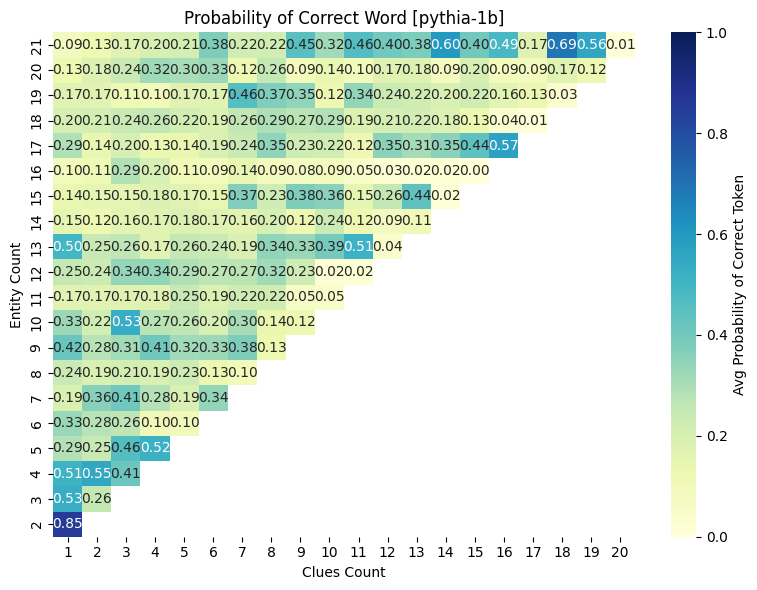

In [8]:
###########################################################################################################
# visualize :

import matplotlib.pyplot as plt
import seaborn as sns

# Pivot the DataFrame so it looks like: rows=entities, columns=transitions
heatmap_data = summary_df.pivot(
    index="entities",
    columns="clues",
    values="avg_correct_prob"
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    vmin=0,
    vmax=1,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={"label": "Avg Probability of Correct Token"}
)

plt.gca().invert_yaxis()

plt.title("Probability of Correct Word [pythia-1b]")
plt.xlabel("Clues Count")
plt.ylabel("Entity Count")
plt.tight_layout()
plt.show()